# CITS5508 Lab 4: AdaBoost and Gradient Boosting Regressor on White wine quality

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook goes through the steps of a typical ensemble classifier (voting classifier) project. It is addressing a multi-class classification task on predicting protein localisation sites using various attributes for E.coli.<br>

Input variables (based on physicochemical tests):<br>
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol<br>

Output variable (based on sensory data):
- 12 - quality (score between 0 and 10)<br>

A Support Vector Machine Classifier, Logistic Regression, and Gradient Descent Classifier are used in ensemble and judged in performance.

Todo:
- [ ] Search for and answer "HELP"

Ask:
- what regressor and base estimator do we use for GradBoost?
- do we have to tune hyperparameters with a gridsearch or think about using a confusion matrix (as the quality can be like a class?)?

## 1. Setup, Data Cleaning and Visualisation
Import libraries to be used and bring the data in. Clean the data for use.<br>
Perform basic visualisations to have a feel of data.<br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pandas.plotting import scatter_matrix
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR #for regression
from sklearn.svm import SVC #EDIT remove
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier #EDIT remove
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings("ignore") #clear warnings

#Prepare the data, separate cols by semi-colon
raw_data = pd.read_csv("winequality-white.csv", delimiter= ";" )

#View first few lines and inspect columns
raw_data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Looking at the first few lines, we observe that the data is all numerical. Hence, there is no need for text handling.

In [2]:
print("These are the output class distribution.")
raw_data["quality"].value_counts() 


These are the output class distribution.


6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

From these class value counts.<br>
Let's **remove class labels with less than 10 instances** due to small class sample size making it unfeasible to predict. #HELP: what about 20? also, while this is a regression task, the quality data seems to be class labels?

In [3]:
#i.e. remove all rows with class = "9"
def clean_data(df): #removes classes with low samples
    c_df = df[ df["quality"]!="9"]
    c_df = c_df.reset_index(drop=True) #renumber index
    print("Are there any missing values?", raw_data.isnull().values.any())
    return c_df

data = clean_data(raw_data)
    
    

Are there any missing values? False


/Users/Joey/anaconda3/envs/cits5508/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


No missing values to clean up.

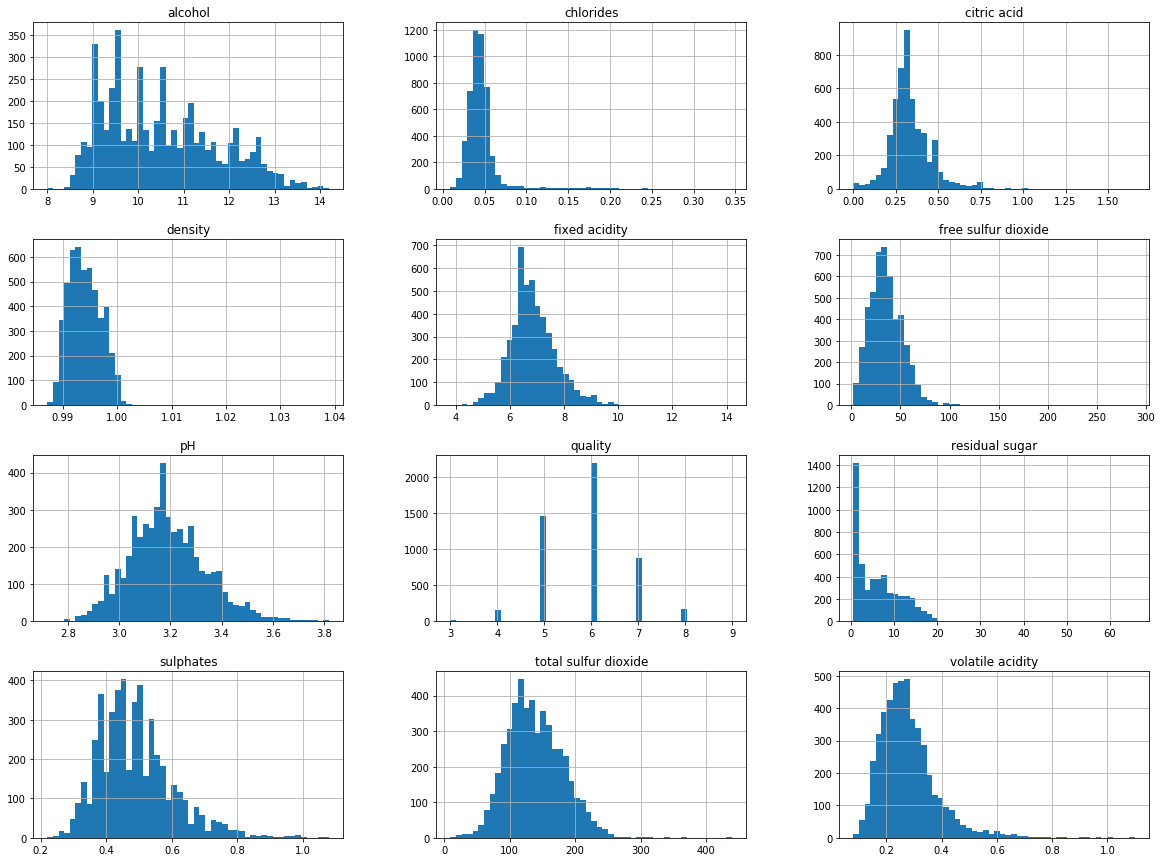

In [4]:
#Generate histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

compute logs for tail heavy dist?
data quirks? like lines in correlation graphs?

These are the graphs showing the distribution for each attribute.<br>
Observations:
- All attributes appear continuous in the sense that from their scale, there is no significant break in value increments. Except for 'quality', which appears to be integers in the range from 3 to 9. Thus, while this may be a regression task, we would likely need to round the predicted outputs.
- All attributes have some normal distribution adherence. 'chlorides', 'citric acid', 'density', 'free sulfur dioxide', 'residual_sugar', and 'violatile acidity' have some degree of positive skew. 


EDIT try a correlation scatter plot?

## 2. Pipeline: Data Splitting and Normalisation
Split dataset then feature scale. 

In [5]:
#Split dataset at 85/15 ratio, separate features and labels
y = data["quality"]
X = data.drop("quality",axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.15, random_state= 0)


## 3. AdaBoost Regressor
Incremental learning by adjusting relative weights of misclassified instances.

In [6]:
#functions used for both AdaBoost and GradientBoost Sections
def displayMSE(title, mse): #function for plotting and printing Mean Sq Errors
    plt.scatter(list(range(1,7)), mse)
    plt.plot(list(range(1,7)), mse)
    plt.title(title)
    plt.ylabel('MSE')
    plt.xlabel('Estimator no.')
    plt.show()
    print("These are the MSEs for each estimator model from first to last:")
    print(mse)
    
#HELP learning curves for MSE?
def getPredictionAndRawErrors(model, features_X, labels_y): #returns raw prediciton errors
    pred = model.predict(features_X) #get prediction values
    pred_round = pred.round() #round predictions and change to integers
    pred_round = pred_round.astype("int64")
    raw_errors = pred_round - labels_y #compute raw prediction errors
    return pred_round, raw_errors

def displayRawErrors(raw_errors,title): #plots raw error histogram
    raw_errors.hist(align= "mid")
    #np.histogram(raw_errors, bins=50)
    #plt.bar(raw_errors)
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

In [7]:
#Prepare regressor
ada_reg = AdaBoostRegressor( 
    base_estimator=SVR(kernel= "rbf"), 
    n_estimators=6, 
    random_state=0)
ada_reg.fit(train_X, train_y) #fit training set

AdaBoostRegressor(base_estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                     epsilon=0.1, gamma='scale', kernel='rbf',
                                     max_iter=-1, shrinking=True, tol=0.001,
                                     verbose=False),
                  learning_rate=1.0, loss='linear', n_estimators=6,
                  random_state=0)

In [8]:
"""
#HELP trying classfier instead, how does this still work?
ada_reg = AdaBoostClassifier( 
    SVC(kernel= "rbf"),algorithm="SAMME", 
    n_estimators=6, 
    random_state=0)
ada_reg.fit(train_X, train_y) #fit training set
""";

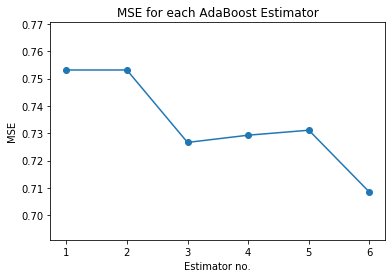

These are the MSEs for each estimator model from first to last:
[0.7531301777149246, 0.7531301777149246, 0.7266474961811511, 0.7292927461330593, 0.7311122719600809, 0.7084639978100752]


In [9]:
#Get MSE for each stage
ada_mse = [mean_squared_error(test_y, test_y_ada_pred) 
             for test_y_ada_pred in ada_reg.staged_predict(test_X)]
#HELP errors with rounded values or raw?
displayMSE("MSE for each AdaBoost Estimator", ada_mse)

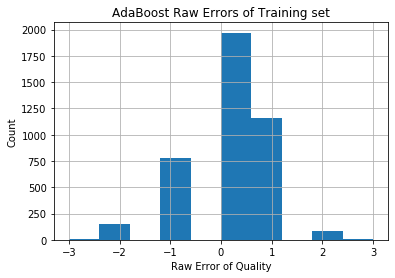

In [10]:
train_ada_pred, train_ada_raw_errors = getPredictionAndRawErrors(ada_reg, train_X, train_y)
displayRawErrors(train_ada_raw_errors,"AdaBoost Raw Errors of Training set")

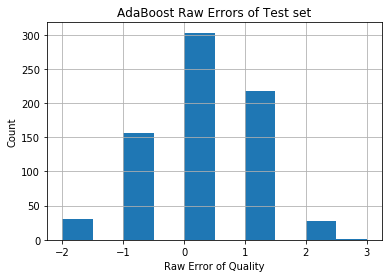

In [11]:
test_ada_pred ,test_ada_raw_errors = getPredictionAndRawErrors(ada_reg, test_X, test_y)
displayRawErrors(test_ada_raw_errors,"AdaBoost Raw Errors of Test set")

## 4. GradientBoost Regressor
Incremental learning by trying to fit estimator on the residuals of previous redisual errors

In [12]:
#Prepare regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=6,
    random_state=0)

gb_reg.fit(train_X, train_y) #fit training set

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=6,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

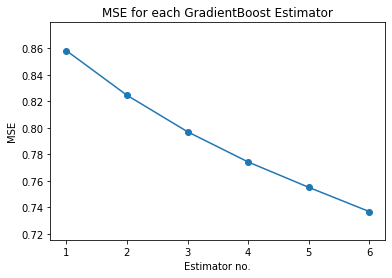

These are the MSEs for each estimator model from first to last:
[0.8584056366855406, 0.8246494426326931, 0.797020726902517, 0.7741712347895023, 0.7549888211349783, 0.7366347785948486]


In [13]:
#Get MSE at each estimator's stage
gb_mse = [mean_squared_error(test_y, test_pred)
         for test_pred in gb_reg.staged_predict(test_X)]

displayMSE("MSE for each GradientBoost Estimator", gb_mse)

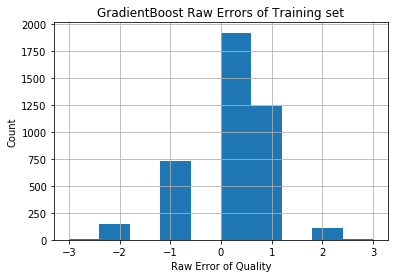

In [14]:
train_gb_pred, train_gb_raw_errors = getPredictionAndRawErrors(gb_reg, train_X, train_y)
displayRawErrors(train_gb_raw_errors,"GradientBoost Raw Errors of Training set")

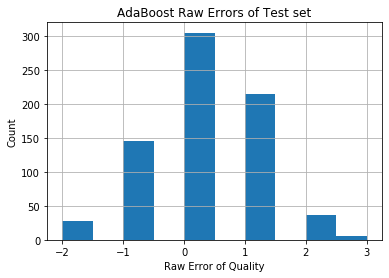

In [15]:
test_gb_pred ,test_gb_raw_errors = getPredictionAndRawErrors(gb_reg, test_X, test_y)
displayRawErrors(test_gb_raw_errors,"AdaBoost Raw Errors of Test set")